# Constrained Light Curve Example

In this example we show how you can use posterior sample chains to generate nice visualisations of constrained lightcurves. Per usual, we begin by importing some modules:


In [1]:
import litmus
import numpy as np
import matplotlib.pyplot as plt
from litmus._utils import dict_extend

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Now generate some mock signals a'la OzDES data:

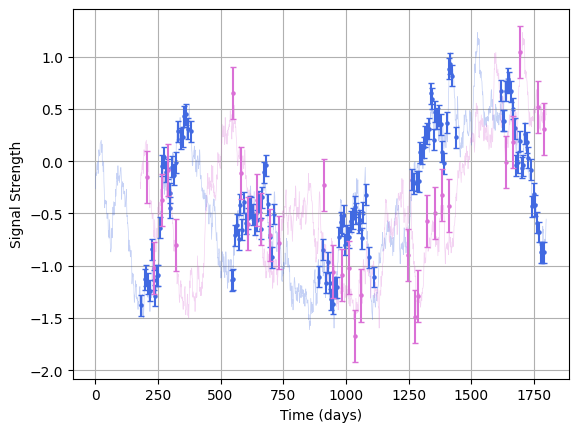

In [2]:
mock = litmus.mocks.mock(lag=180,
                         E=[0.1, 0.25],
                         tau=400)
lc_1, lc_2 = mock.lc_1, mock.lc_2
mock.plot()
plt.show()

Now create a `LITMUS` model, specifically the `GP_simple` model. We'll leave the priors at their defaults for `lag` and `logtau`, but restrict the others at their true values to make fitting easier for this simple example.

While we're at it, we'll convert the two lightcurves into the right format for the model's data input, and define the time span we want to track the lightcurves over, and make the change of setting the model's logging to `verbose=True` so we can track its progress.

In [12]:
model = litmus.models.GP_simple(verbose=False,
                                debug=False,
                                prior_ranges=mock.params() | {'lag': [0, 1_000], 'logtau': [np.log(10), np.log(10000)]})
data = model.lc_to_data(lc_1, lc_2)
Tpred = np.linspace(-1000, 2500, 512)

Light curve constrain works via the stats model itself. We feed in the data to condition the model and some model paramters for constraining the model. Because we're working with a mock, we already know the underlying true model paramters, and can get them from `mock.params()`:

In [13]:
p = mock.params()
pred1_true, pred2_true = model.make_lightcurves(data, params=p, Tpred=Tpred, num_samples=1)

Because we're going to run the code again we'll wrap the plot generation in a function:

In [14]:
def make_plot(pred1, pred2):
    print("Predictions Clear. Plotting")
    c0 = 'midnightblue'
    c1, c2 = 'navy', 'orchid'

    f, (a1, a2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    lc_1.plot(axis=a1, show=False, c=c1, capsize=2, label="Measurements")
    lc_2.plot(axis=a2, show=False, c=c2, capsize=2, label="Measurements")

    a1.plot(mock.lc.T, mock.lc.Y, c=c0, lw=0.5, zorder=-6, label='True Signal')
    a2.plot(mock.lc.T + mock.lag, mock.lc.Y, c=c0, lw=0.5, zorder=-6)

    a1.fill_between(pred1.T, pred1.Y - pred1.E, pred1.Y + pred1.E, alpha=0.25, color=c1,
                    label="Constrained Lightcurve, Continuum")
    a2.fill_between(pred2.T, pred2.Y - pred2.E, pred2.Y + pred2.E, alpha=0.25, color=c2,
                    label="Constrained Lightcurve, Response")
    a1.fill_between(pred1.T, pred1.Y - 2 * pred1.E, pred1.Y + 2 * pred1.E, alpha=0.125, color=c1)
    a2.fill_between(pred2.T, pred2.Y - 2 * pred2.E, pred2.Y + 2 * pred2.E, alpha=0.125, color=c2)

    r = 0.1
    a1.fill_between(pred1.T, pred1.Y - 2 * pred1.E - r, pred1.Y + 2 * pred1.E + r, alpha=1.0, color='w', zorder=-9)
    a2.fill_between(pred2.T, pred2.Y - 2 * pred2.E - r, pred2.Y + 2 * pred2.E + r, alpha=1.0, color='w', zorder=-9)

    f.supxlabel("Time (Days)")
    f.supylabel("Signal (Arb Units)")

    for a in a1, a2:
        a.grid()
        a.set_yticklabels([])
        a.set_ylim(-3, 3)

        if mock.season != 0:
            tmax = Tpred.max()
            nyears = int(tmax // (mock.season * 2) + 1)
            for i in range(nyears):
                a.axvspan((i + 1 / 2 - 1 / 2) * mock.season * 2, (i + 1 - 1 / 2) * mock.season * 2,
                          ymin=0, ymax=1, alpha=0.125, color='royalblue',
                          zorder=-10,
                          label=None)
            a.legend()

    a1.set_xlim(0, 2000)
    f.tight_layout()

    print("Plots done")

    return (f)

And run it:

Predictions Clear. Plotting
Plots done


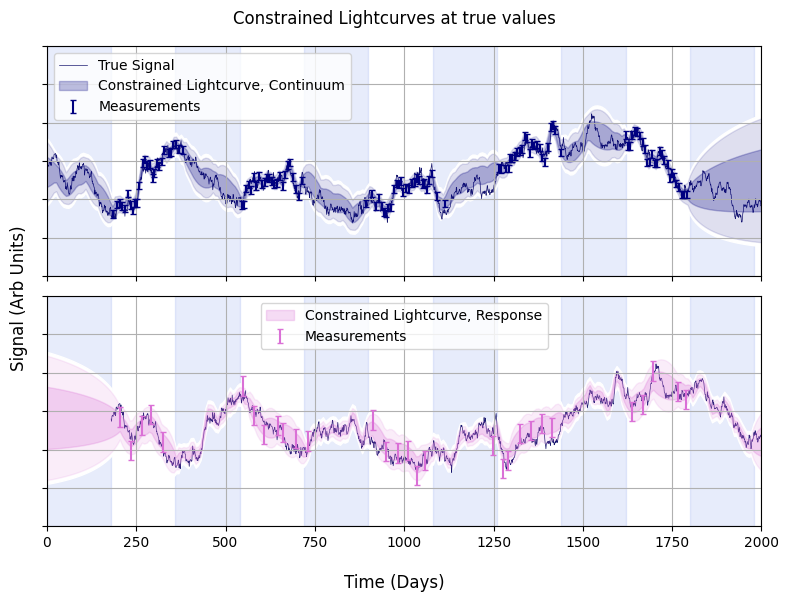

In [15]:
f = make_plot(pred1_true, pred2_true)
f.suptitle("Constrained Lightcurves at true values")
f.tight_layout()
f.show()

That's not all though, we can also feed in an MCMC-like chain of parameters to have `model.make_lightcurve` marginalize over the posterior. First we'll need to actually set the 

In [16]:
my_fitter = litmus.fitting_methods.hessian_scan(model, verbose=False, debug=False, grid_bunching = 0.25, Nlags = 128)
my_fitter.fit(lc_1, lc_2)
p_varied = my_fitter.get_samples()

We'll wrap a `LITMUS` plotter around this method to check what the parameters are doing and make sure we have a nice result. We can notice that, while the parameters are well constrained, the timescale skews slightly above the $\log\vert400 \mathrm{d} \vert=5.99$ of the underlying mock signal:

Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. 

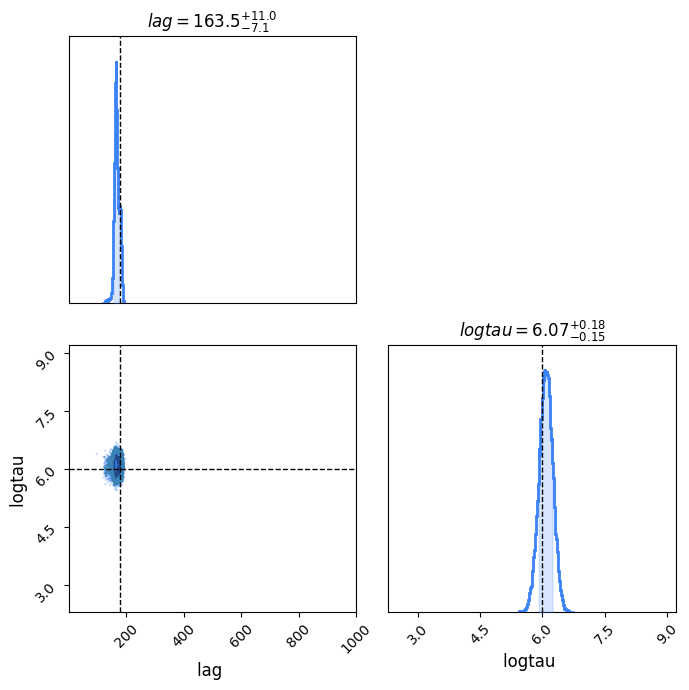

In [19]:
lt = litmus.LITMUS(my_fitter)
lt.plot_parameters(prior_extents = True, truth=mock.params())
plt.show()

What does this mean for the constraints on the lightcurve? Well, two effects are present: 
1. The uncertainty in the lag smudges the response lightcurve laterally
2. The skewing of the timescale towards larger values means our predictions are smoothed out
The net result is that the final constrained lightcurve is smoother and blurrier in the time-axis when we account for our measurement uncertainties. How do we test this with `LITMUS`? Simple: we `.get_samples()` from `my_fitter` to get an MCMC-like chain and feed this to `make_lightcurves` before plotting: 

Predictions Clear. Plotting
Plots done


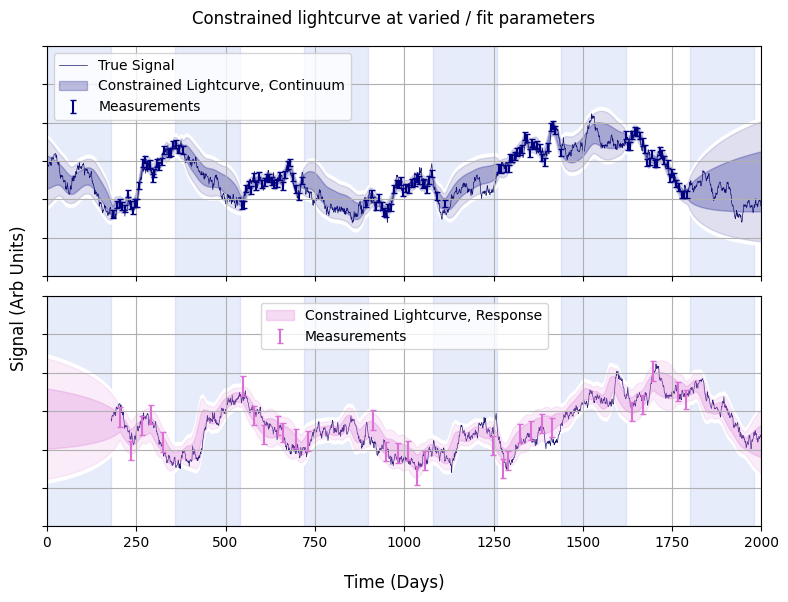

In [18]:
p_varied = my_fitter.get_samples(N=512)
pred1_vary, pred2_vary = model.make_lightcurves(data, params=p_varied, Tpred=Tpred, num_samples=64)
f = make_plot(pred1_vary, pred2_vary)
f.suptitle("Constrained lightcurve at varied / fit parameters")
f.tight_layout()
f.show()

We can see that the plots are smoothed out by the uncertainty in $\Delta t$ and $\tau$, which skews somewhat towards longer timescales.